In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

In [2]:
from google.colab import drive  #using the google drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data loader**

In [3]:
from glob import glob
import cv2
images_path = '/content/drive/MyDrive/BIG DATA/train/train/*/*.png' #load the data from the google drive

images = glob(images_path)
train_images = []
train_labels = []

for img in images:
    train_images.append(cv2.resize(cv2.imread(img), (256, 256))) #image is 256x256x3
    train_labels.append(img.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [4]:
train_Y

,0
0,Shepherds Purse
1,Shepherds Purse
2,Shepherds Purse
3,Shepherds Purse
4,Shepherds Purse
...,...
4745,Small-flowered Cranesbill
4746,Small-flowered Cranesbill
4747,Small-flowered Cranesbill
4748,Small-flowered Cranesbill


In [5]:
train_X.shape #4750 images, 256*256, 3 channels

(4750, 256, 256, 3)

In [6]:
train_Y.rename(columns={0:'species'},inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
le = LabelEncoder()
le.fit(train_Y['species'])
encoded_labels = le.transform(train_Y['species'])
train_label = np_utils.to_categorical(encoded_labels) #Number to Binary

In [8]:
#seed fixing
import random
import os
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

**Data Split**

In [9]:
from sklearn.model_selection import train_test_split #X=DATA Y=LABEL, 0.8 train, 0.2 test
X_train,X_test,Y_train,Y_test=train_test_split(train_X, train_label,test_size=0.2,random_state=seed, stratify=train_label) 

In [10]:
X_test.shape #950 test images

(950, 256, 256, 3)

In [11]:
Y_test.shape #950 test labels

(950, 12)

In [12]:
X_train.shape #3800 train labels

(3800, 256, 256, 3)

In [13]:
Y_train.shape #3800 train labels

(3800, 12)

**Data normalization**

In [15]:
# Normalization 
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

**Data generator**

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagenerator = ImageDataGenerator(
        horizontal_flip=True,  #Horizontal flip 
        vertical_flip=True,  #Up and down reversal
        rotation_range=180,  #Rotation angle
        shear_range=0.1,  #Distortions
        zoom_range = 0.1, #Zoom in and out
        width_shift_range=0.1,  #Up, down, left and right shift   
        height_shift_range=0.1 
    )  
datagenerator.fit(train_X)

In [17]:
X_train[0]

array([[[0.0627451 , 0.0627451 , 0.09411765],
        [0.07058824, 0.06666667, 0.09803922],
        [0.07450981, 0.06666667, 0.10196079],
        ...,
        [0.12156863, 0.10980392, 0.13333334],
        [0.10588235, 0.10196079, 0.1254902 ],
        [0.14509805, 0.14117648, 0.16078432]],

       [[0.09019608, 0.08627451, 0.12156863],
        [0.0627451 , 0.05490196, 0.09411765],
        [0.04705882, 0.03529412, 0.08235294],
        ...,
        [0.1254902 , 0.11372549, 0.13725491],
        [0.10588235, 0.09803922, 0.12156863],
        [0.12941177, 0.12941177, 0.14509805]],

       [[0.09803922, 0.09803922, 0.12941177],
        [0.12941177, 0.12941177, 0.15294118],
        [0.08627451, 0.08235294, 0.11372549],
        ...,
        [0.12156863, 0.10980392, 0.14117648],
        [0.10588235, 0.09803922, 0.12941177],
        [0.14117648, 0.14117648, 0.16862746]],

       ...,

       [[0.05490196, 0.10196079, 0.22745098],
        [0.08627451, 0.14901961, 0.29411766],
        [0.09019608, 0

**Create CNN model**

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

model = Sequential()

############# layer 1 ###########################
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 3),padding = 'Same', activation='relu')) #padding = 1, ReLU
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

############# layer 2 ###########################
model.add(Conv2D(filters=64, kernel_size=(3, 3),padding = 'Same', activation='relu')) 
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

############# layer 3 ###########################
model.add(Conv2D(filters=128, kernel_size=(3, 3),padding = 'Same', activation='relu'))
model.add(BatchNormalization(axis=3))
# model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

############# layer 4 ###########################
model.add(Conv2D(filters=256, kernel_size=(3, 3),padding = 'Same', activation='relu'))
model.add(BatchNormalization(axis=3))
# model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))


########## fully connected ##########
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1)) 
model.add(Dense(12, activation='softmax'))
 

# model.summary()

**optimizer using Adama**

In [20]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam(learning_rate=0.0001, decay=0.0001/20) 

In [22]:
#Specify Lass and Optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

**Fit the model**

In [24]:
history = model.fit(datagenerator.flow(X_train, Y_train, batch_size=64), 
                    epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
60/60 [==============================] - 49s 759ms/step - loss: 0.7838 - accuracy: 0.7471 - val_loss: 7.0178 - val_accuracy: 0.0495
Epoch 2/20
60/60 [==============================] - 46s 765ms/step - loss: 0.6618 - accuracy: 0.7758 - val_loss: 6.6497 - val_accuracy: 0.0611
Epoch 3/20
60/60 [==============================] - 46s 765ms/step - loss: 0.5955 - accuracy: 0.8021 - val_loss: 5.9697 - val_accuracy: 0.1663
Epoch 4/20
60/60 [==============================] - 46s 763ms/step - loss: 0.5295 - accuracy: 0.8216 - val_loss: 4.9123 - val_accuracy: 0.2232
Epoch 5/20
60/60 [==============================] - 46s 762ms/step - loss: 0.4924 - accuracy: 0.8347 - val_loss: 3.3714 - val_accuracy: 0.3295
Epoch 6/20
60/60 [==============================] - 46s 765ms/step - loss: 0.4788 - accuracy: 0.8368 - val_loss: 2.4160 - val_accuracy: 0.4368
Epoch 7/20
60/60 [==============================] - 47s 786ms/step - loss: 0.4547 - accuracy: 0.8500 - val_loss: 1.3278 - val_accuracy: 0.6105

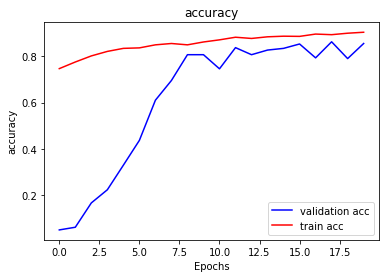

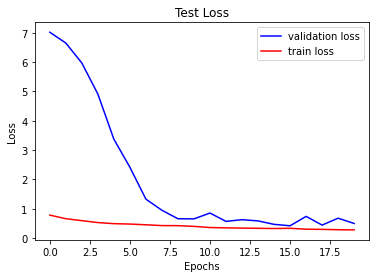

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], color='b', label="validation acc")
plt.plot(history.history['accuracy'], color='r', label="train acc")
plt.title("accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="train loss")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/BIG DATA/models', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#Stop fitting if there's no enhancement of accuracy for 10 times.

In [22]:
#Specify Lass and Optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(datagenerator.flow(X_train, Y_train, batch_size=64), 
                    epochs=30, validation_data=(X_test, Y_test),
                    callbacks = [early_stopping, model_checkpoint])

Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 1.6832 - accuracy: 0.5024
Epoch 1: val_accuracy improved from -inf to 0.13789, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 81s 1s/step - loss: 1.6832 - accuracy: 0.5024 - val_loss: 4.0398 - val_accuracy: 0.1379
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.9452 - accuracy: 0.6932
Epoch 2: val_accuracy did not improve from 0.13789
60/60 [==============================] - 56s 925ms/step - loss: 0.9452 - accuracy: 0.6932 - val_loss: 6.1330 - val_accuracy: 0.1379
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.7464 - accuracy: 0.7553
Epoch 3: val_accuracy did not improve from 0.13789
60/60 [==============================] - 55s 909ms/step - loss: 0.7464 - accuracy: 0.7553 - val_loss: 8.1287 - val_accuracy: 0.1379
Epoch 4/30
60/60 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.7895
Epoch 4: val_accuracy did not improve from 0.13789
60/60 [==============================] - 47s 777ms/step - loss: 0.6483 - accuracy: 0.7895 - val_loss: 9.4283 - val_accuracy: 0.1358
Epoch 5/30
60/60 [======================

60/60 [==============================] - 65s 1s/step - loss: 0.5708 - accuracy: 0.8063 - val_loss: 10.7020 - val_accuracy: 0.1516
Epoch 6/30
60/60 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.8332
Epoch 6: val_accuracy improved from 0.15158 to 0.15474, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 71s 1s/step - loss: 0.5044 - accuracy: 0.8332 - val_loss: 9.7531 - val_accuracy: 0.1547
Epoch 7/30
60/60 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.8413
Epoch 7: val_accuracy improved from 0.15474 to 0.18316, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 69s 1s/step - loss: 0.4641 - accuracy: 0.8413 - val_loss: 7.6866 - val_accuracy: 0.1832
Epoch 8/30
60/60 [==============================] - ETA: 0s - loss: 0.4269 - accuracy: 0.8561
Epoch 8: val_accuracy improved from 0.18316 to 0.24526, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 69s 1s/step - loss: 0.4269 - accuracy: 0.8561 - val_loss: 5.1118 - val_accuracy: 0.2453
Epoch 9/30
60/60 [==============================] - ETA: 0s - loss: 0.4004 - accuracy: 0.8634
Epoch 9: val_accuracy improved from 0.24526 to 0.36000, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 73s 1s/step - loss: 0.4004 - accuracy: 0.8634 - val_loss: 3.3961 - val_accuracy: 0.3600
Epoch 10/30
60/60 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8682
Epoch 10: val_accuracy improved from 0.36000 to 0.54737, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 69s 1s/step - loss: 0.3931 - accuracy: 0.8682 - val_loss: 2.0631 - val_accuracy: 0.5474
Epoch 11/30
60/60 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8674
Epoch 11: val_accuracy improved from 0.54737 to 0.69053, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 69s 1s/step - loss: 0.3745 - accuracy: 0.8674 - val_loss: 1.4169 - val_accuracy: 0.6905
Epoch 12/30
60/60 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8784
Epoch 12: val_accuracy improved from 0.69053 to 0.79579, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 69s 1s/step - loss: 0.3517 - accuracy: 0.8784 - val_loss: 0.7134 - val_accuracy: 0.7958
Epoch 13/30
60/60 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8918
Epoch 13: val_accuracy did not improve from 0.79579
60/60 [==============================] - 52s 860ms/step - loss: 0.3090 - accuracy: 0.8918 - val_loss: 0.8368 - val_accuracy: 0.7674
Epoch 14/30
60/60 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.8913
Epoch 14: val_accuracy did not improve from 0.79579
60/60 [==============================] - 50s 834ms/step - loss: 0.3163 - accuracy: 0.8913 - val_loss: 0.6808 - val_accuracy: 0.7842
Epoch 15/30
60/60 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.8926
Epoch 15: val_accuracy improved from 0.79579 to 0.81263, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 67s 1s/step - loss: 0.3212 - accuracy: 0.8926 - val_loss: 0.5519 - val_accuracy: 0.8126
Epoch 16/30
60/60 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8934
Epoch 16: val_accuracy improved from 0.81263 to 0.84632, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 70s 1s/step - loss: 0.2914 - accuracy: 0.8934 - val_loss: 0.4954 - val_accuracy: 0.8463
Epoch 17/30
60/60 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.9016
Epoch 17: val_accuracy improved from 0.84632 to 0.85684, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 68s 1s/step - loss: 0.2819 - accuracy: 0.9016 - val_loss: 0.4291 - val_accuracy: 0.8568
Epoch 18/30
60/60 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.8955
Epoch 18: val_accuracy did not improve from 0.85684
60/60 [==============================] - 53s 878ms/step - loss: 0.2939 - accuracy: 0.8955 - val_loss: 0.5854 - val_accuracy: 0.8347
Epoch 19/30
60/60 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9050
Epoch 19: val_accuracy improved from 0.85684 to 0.86421, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 68s 1s/step - loss: 0.2792 - accuracy: 0.9050 - val_loss: 0.3939 - val_accuracy: 0.8642
Epoch 20/30
60/60 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.8989
Epoch 20: val_accuracy improved from 0.86421 to 0.86526, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 67s 1s/step - loss: 0.2707 - accuracy: 0.8989 - val_loss: 0.4719 - val_accuracy: 0.8653
Epoch 21/30
60/60 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9116
Epoch 21: val_accuracy did not improve from 0.86526
60/60 [==============================] - 54s 900ms/step - loss: 0.2556 - accuracy: 0.9116 - val_loss: 0.4402 - val_accuracy: 0.8400
Epoch 22/30
60/60 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9205
Epoch 22: val_accuracy improved from 0.86526 to 0.88842, saving model to /content/drive/MyDrive/BIG DATA/models


60/60 [==============================] - 68s 1s/step - loss: 0.2444 - accuracy: 0.9205 - val_loss: 0.3404 - val_accuracy: 0.8884
Epoch 23/30
60/60 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9158
Epoch 23: val_accuracy did not improve from 0.88842
60/60 [==============================] - 50s 834ms/step - loss: 0.2408 - accuracy: 0.9158 - val_loss: 0.8713 - val_accuracy: 0.7179
Epoch 24/30
60/60 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.9174
Epoch 24: val_accuracy did not improve from 0.88842
60/60 [==============================] - 51s 842ms/step - loss: 0.2468 - accuracy: 0.9174 - val_loss: 0.4595 - val_accuracy: 0.8600
Epoch 25/30
60/60 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9229
Epoch 25: val_accuracy did not improve from 0.88842
60/60 [==============================] - 52s 856ms/step - loss: 0.2311 - accuracy: 0.9229 - val_loss: 0.4969 - val_accuracy: 0.8411
Epoch 26/30
60/60 [===============

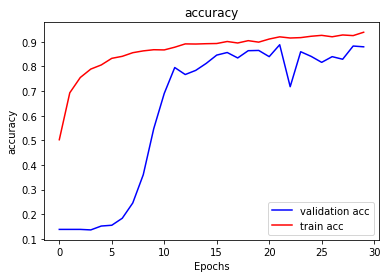

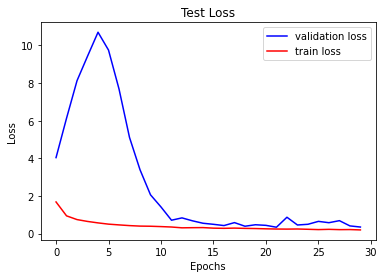

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], color='b', label="validation acc")
plt.plot(history.history['accuracy'], color='r', label="train acc")
plt.title("accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="train loss")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)    

**Do the prediction**

In [49]:
test_images_path = '/content/drive/MyDrive/BIG DATA/test/test/*.png'
test_images = glob(test_images_path)
test_images_arr = []
test_files = []

for img in test_images:
    test_images_arr.append(cv2.resize(cv2.imread(img), (256, 256)))
    test_files.append(img.split('/')[-1])

test_X = np.asarray(test_images_arr)

In [50]:
# Normalization of the Image Data
test_X = test_X.astype('float32') / 255

In [51]:
pred = model.predict(test_X)
pred_class = np.argmax(pred, axis=1)
pred_str = le.classes_[pred_class]
#final_predictions

25/25 [==============================] - 2s 89ms/step


In [52]:
print(pred_str)

['Fat Hen' 'Loose Silky-bent' 'Common Chickweed' 'Common Chickweed'
 'Common wheat' 'Loose Silky-bent' 'Sugar beet' 'Fat Hen'
 'Loose Silky-bent' 'Fat Hen' 'Cleavers' 'Common wheat' 'Common Chickweed'
 'Scentless Mayweed' 'Common Chickweed' 'Common Chickweed' 'Common wheat'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Shepherds Purse'
 'Sugar beet' 'Sugar beet' 'Fat Hen' 'Charlock' 'Common wheat'
 'Common Chickweed' 'Fat Hen' 'Cleavers' 'Sugar beet' 'Charlock' 'Maize'
 'Common Chickweed' 'Common Chickweed' 'Charlock' 'Loose Silky-bent'
 'Scentless Mayweed' 'Cleavers' 'Loose Silky-bent' 'Maize'
 'Common Chickweed' 'Scentless Mayweed' 'Scentless Mayweed'
 'Shepherds Purse' 'Loose Silky-bent' 'Charlock' 'Cleavers'
 'Common Chickweed' 'Loose Silky-bent' 'Fat Hen' 'Scentless Mayweed'
 'Sugar beet' 'Loose Silky-bent' 'Sugar beet' 'Scentless Mayweed'
 'Shepherds Purse' 'Shepherds Purse' 'Black-grass' 'Common Chickweed'
 'Sugar beet' 'Common wheat' 'Shepherds Purse' 'Fat Hen' 'Sugar beet'
 